In [1]:
# Hyperparameters
seq_length = 30 #window
batch_size = 16
hidden_size = 4  # Number of neurons in the hidden layers
num_layers = 1  # Number of hidden layers
learning_rate = 0.0001
num_epochs = 100
starting_point =  50 #cutoff first 50 points

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

#path_dir = 'data/31-1-25/'

In [3]:
def normalize(train_data):
    mins = np.min(train_data, axis=1, keepdims=True)
    maxs = np.max(train_data, axis=1, keepdims=True)
    normalized_train = (train_data - mins) / (maxs - mins)
    params = {'mins': mins, 'maxs': maxs}   
    return normalized_train, params

def denormalize(normalized_train, params):
    mins = params['mins']
    maxs = params['maxs']
    denormalized_train = normalized_train * (maxs - mins) + mins    
    return denormalized_train

In [4]:
"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t
"""

#"""
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
#"""

train_data = load_data('data/31-1-25/')
test_data = load_data('data/21-2-25/')
train_data, train_param = normalize(train_data)
test_data, test_param = normalize(test_data)

In [5]:
def prep_data(data, seq_length, step=1):
    input_data = data[0]
    output_data = data[1]
    time_data = data[2]
    xs, ys = [], []
    for i in range(starting_point, len(input_data) - seq_length, step):
        x = input_data[i:i + seq_length]
        t = time_data[i:i + seq_length]
        y = output_data[i:i + seq_length]
        
        slope2, slope, intercept = np.polyfit(t, x, 2)
        mean = np.mean(x)
        std = np.std(x)
        #slope = slope*10**5 #Scaling, because some numbers were to small. So now it has somewhat similar range.
        #slope2 = slope2*10**8
        #std = std*10**1
        xs.append((slope2, slope, intercept, mean, std))

        slope2, slope, intercept = np.polyfit(t, y, 2)
        mean = np.mean(y)
        std = np.std(y)
        #slope = slope*10**5
        #slope2 = slope2*10**8
        #std = std*10**1
        ys.append((slope2, slope, intercept, mean, std))
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    X_train = torch.tensor(xs, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    return X_train, y_train

X_train, y_train = prep_data(train_data, seq_length)
X_test, y_test = prep_data(test_data, seq_length)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [7]:
# Define the MLP model
'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
'''

'\nclass MLP(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(MLP, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size)\n        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)\n        self.fc3 = nn.Linear(hidden_size // 2, output_size)\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        out = self.fc1(x)\n        out = self.relu(out)\n        out = self.fc2(out)\n        out = self.relu(out)\n        out = self.fc3(out)\n        return out\n'

In [8]:
#'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer
        self.relu = nn.ReLU()  # Activation function
        self.prelu = nn.PReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)  # Pass through the hidden layer
        #out = self.relu(out)  # Apply ReLU activation
        out = self.tanh(out)
        out = self.fc2(out)  # Pass through the output layer
        return out
#'''

In [9]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Training loop
def train(dataloader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: (batch_size, seq_length)
            loss = criterion(outputs, batch_y)  # Ensure shapes match
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataloader)

Epoch [10/100], Loss: 0.5225
Epoch [20/100], Loss: 0.3330
Epoch [30/100], Loss: 0.1939
Epoch [40/100], Loss: 0.0984
Epoch [50/100], Loss: 0.0427
Epoch [60/100], Loss: 0.0202
Epoch [70/100], Loss: 0.0163
Epoch [80/100], Loss: 0.0162
Epoch [90/100], Loss: 0.0162
Epoch [100/100], Loss: 0.0162


Trenovaci
x data: [0.47959905 0.47599213 0.48293045 0.4843824  0.50091571 0.48974377
 0.47947882 0.47754839 0.4828603  0.48744334 0.48323155 0.47672372
 0.49447686 0.48726204 0.49298464 0.50063745 0.49044882 0.49595453
 0.4839798  0.49913106 0.4976363  0.49280664 0.48124601 0.47542695
 0.48229239 0.52029276 0.52116006 0.51982223 0.52265572 0.50433949]
t data: [0.73594014 0.73618151 0.73642288 0.73666425 0.73690562 0.73714699
 0.73738837 0.73762974 0.73787111 0.73811248 0.73835385 0.73859522
 0.73883659 0.73907796 0.73931933 0.7395607  0.73980208 0.74004345
 0.74028482 0.74052619 0.74076756 0.74100893 0.7412503  0.74149167
 0.74173304 0.74197441 0.74221579 0.74245716 0.74269853 0.7429399 ]
result: 0.2639054875728063
x data: [0.48492358 0.4945038  0.48535098 0.47442322 0.46724246 0.46554117
 0.46847826 0.49107337 0.47200953 0.48041702 0.49859017 0.50732167
 0.49032298 0.47583108 0.47362792 0.47920603 0.45036252 0.47135665
 0.47968573 0.46966755 0.49831134 0.48060238 0.48813249 0.49750722

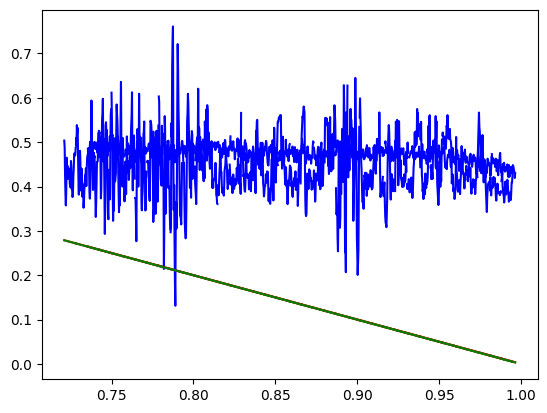

In [16]:
#slope2, slope, intercept, mean, std

def eval(data):
    model.eval()
    with torch.no_grad():
        
        input_data = data[0]
        output_data = data[1]
        time_data = data[2]
        for i in range(3000, len(input_data) - seq_length, seq_length):
            x = input_data[i:i + seq_length]
            t = time_data[i:i + seq_length]
            y = output_data[i:i + seq_length]
            print(f"x data: {x}")
            print(f"t data: {t}")

            slope2, slope, intercept = np.polyfit(t, x, 2)
            mean = np.mean(x)
            std = np.std(x)
            #slope = slope*10**(5)
            #slope2 = slope2*10**(8)
            #std = std*10**(1)
            X = torch.tensor((slope2, slope, intercept, mean, std), dtype=torch.float32)
            #print(f"X = {X}")
            pred = model(X).numpy()
            #reg = 10**(-8)*pred[0]*t**2 + 10**(-5)*pred[1]*t + pred[2] #Unscaling the numbers back
            reg = pred[0]*t**2 + pred[1]*t + pred[2] #Unscaling the numbers back
            print(f"result: {reg[0]}")
            
            plt.plot(t, x, c='blue', label="baterie[V]")
            plt.plot(t, y, c='red', label="realna odhadovana kapacita[%]")
            plt.plot(t, reg, c='green', label="predikovana kapacita [%]")
            if (i <= starting_point): #otherwise it will print more than once
                plt.legend()
            #plt.errorbar(t[0], pred[3], pred[4], linestyle='None')
            #plt.scatter(t[0], pred[3], color="black", linewidth=1)

        #plt.show()

print("Trenovaci")
eval(train_data)
#plt.savefig("pow_train.png")
#plt.show()
print("Testovaci")
eval(test_data)
#plt.savefig("pow_test.png")
#plt.show()

In [15]:
# Save the state dictionary and architecture parameters
checkpoint = {
    'seq_length': seq_length,
    'num_layers': num_layers,
    'starting_point': starting_point,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'output_size': output_size,
    'state_dict': model.state_dict(),
}
torch.save(checkpoint, 'motor_model.pth')